In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import pandas as pd
import numpy as np
import re
import os
import time
import dask.dataframe as dd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()
total_unique_customers = None

In [2]:
start_time = time.time()
cluster = SLURMCluster()

In [3]:
cluster.scale(6)

In [4]:

client = Client(cluster)
client

Client Scheduler: tcp://128.119.244.138:34861 Dashboard: http://128.119.244.138:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
dir_path = '/mnt/nfs/work1/jtaneja/jmugyenyi/'
# Consumption data 2014-2020 B.csv
# /home/jmugyenyi/REG/
filename = 'reg_data_combined.csv'
filepath = os.path.join(dir_path, filename)

In [6]:
%%time
df = dd.read_csv(filepath)
# df = dd.read_csv(filepath,dtype=dict(consumer_id=str))
df = client.persist(df)
progress(df)

CPU times: user 3.28 s, sys: 88.5 ms, total: 3.37 s
Wall time: 3.33 s


VBox()

In [7]:
%%time
total_unique_customers = df.consumer_id.nunique().compute()
customer_str =  (f'Total consumers: {total_unique_customers}')
print(customer_str)

Total consumers: 833621
CPU times: user 7.82 s, sys: 744 ms, total: 8.56 s
Wall time: 2min 12s


### Multiple Vending categories


In [7]:
%%time
df_tmp8 =df.map_partitions(lambda x: x.groupby(x.consumer_id)["vending_category_name"].nunique()).compute()
print(f'count of customers with  vending categories =1 is: {len(df_tmp8[df_tmp8==1])}')
print(f'count of customers with  vending categories =2 is: {len(df_tmp8[df_tmp8==2])}')
print(f'count of customers with  vending categories =3 is: {len(df_tmp8[df_tmp8==3])}')
print(f'count of customers with  vending categories =4 is: {len(df_tmp8[df_tmp8==4])}')
print(f'count of customers with  vending categories =5 is: {len(df_tmp8[df_tmp8==5])}')
print(f'count of customers with  vending categories =6 is: {len(df_tmp8[df_tmp8==6])}')
print(f'count of customers with  vending categories >6 is: {len(df_tmp8[df_tmp8>6])}')

count of customers with  vending categories =1 is: 11944208
count of customers with  vending categories =2 is: 59903
count of customers with  vending categories =3 is: 383
count of customers with  vending categories =4 is: 23
count of customers with  vending categories =5 is: 1
count of customers with  vending categories =6 is: 0
count of customers with  vending categories >6 is: 0
CPU times: user 17.4 s, sys: 2.86 s, total: 20.3 s
Wall time: 3min 39s


In [25]:
len(df_tmp8[df_tmp8==1])

11944208

### Filter out a single customer's history

In [17]:
%%time
new_df = df
new_df['consumer_id'] = new_df['consumer_id'].str.replace(" ","")
group = new_df.groupby(['consumer_id'])
# group.groups.keys()
single_customer = group.get_group('133934').compute() # 20151203 124004.316 0002012 9712  174650
# single_customer = single_customer[['transaction_item_type','tariff_name','transaction_date','installation_date','block_amount','kWh_sold','amount']] #,'tariff_name','kWh_sold','amount'
# single_customer ['block_amount*kWh_sold']= single_customer['block_amount']*single_customer['kWh_sold']
single_customer.head(3)
len(single_customer)



CPU times: user 6.46 s, sys: 401 ms, total: 6.86 s
Wall time: 2min 55s


2488

In [18]:
single_customer.tail(3)

,meter_serial_number,consumer_id,consumer_unit_id,poc_id,poc_unit_id,transaction_date,vending_category_id,vending_category_name,transaction_item_type,block_index,block_start_value,block_amount,tariff_name,kWh_sold,amount,installation_date,district_id,district
295179,4206332266,133934,8188,132398,8188,2012-01-16 08:46:47.010000000,8,2. CS T1 Tx AR STS,TAX,NaN,NaN,NaN,TVA tax,0.0,305.0,2010-02-02 17:33:09,25,MUSANZE
112760,4206332266,133934,8188,132398,8188,2011-12-30 08:41:49.733000000,8,2. CS T1 Tx AR STS,TAX,NaN,NaN,NaN,TVA tax,0.0,305.0,2010-02-02 17:33:09,25,MUSANZE
114123,4206332266,133934,8188,132398,8188,2012-01-05 09:56:39.840000000,8,2. CS T1 Tx AR STS,TAX,NaN,NaN,NaN,TVA tax,0.0,305.0,2010-02-02 17:33:09,25,MUSANZE


In [19]:
%%time
temp = single_customer[single_customer['transaction_item_type']=='TARIFF']
temp[temp['block_amount'].isna()]

CPU times: user 4.42 ms, sys: 48 µs, total: 4.47 ms
Wall time: 3.92 ms


,meter_serial_number,consumer_id,consumer_unit_id,poc_id,poc_unit_id,transaction_date,vending_category_id,vending_category_name,transaction_item_type,block_index,block_start_value,block_amount,tariff_name,kWh_sold,amount,installation_date,district_id,district
189036,4206332266,133934,8188,132398,8188,2017-01-04 16:38:49.557000000,13,11. Non Residential,TARIFF,NaN,NaN,NaN,Non Residential,31.4,6034.0,2010-02-02 17:33:10,25,MUSANZE


In [20]:
single_customer.vending_category_name.unique()

array(['11. Non Residential', '2. CS T1 Tx AR STS'], dtype=object)

In [21]:

fname = '133934'+'.csv'
fpath = os.path.join(dir_path, fname)
single_customer.to_csv(fpath,index=False,header=True)

In [7]:
%%time
df.head()


CPU times: user 5.31 s, sys: 217 ms, total: 5.53 s
Wall time: 53.8 s


,meter_serial_number,consumer_id,consumer_unit_id,poc_id,poc_unit_id,transaction_date,vending_category_id,vending_category_name,transaction_item_type,block_index,block_start_value,block_amount,tariff_name,kWh_sold,amount,installation_date,district_id,district,months_since_installation,y
0,4230304885,20140130 103411.970 0002014 0109,2014,20140130 103541.039 0002014 0159,2014,2017-11-17 17:25:41.937,13,11. Non Residential,TAX,NaN,NaN,NaN,TVA tax,0.0,304.000,2014-01-30 10:35:55,106,KIGALI,45.579074,2014
1,4230304885,20140130 103411.970 0002014 0109,2014,20140130 103541.039 0002014 0159,2014,2017-09-16 19:22:02.577,13,11. Non Residential,TAX,NaN,NaN,NaN,Regulatory_Fee,0.0,5.000,2014-01-30 10:35:55,106,KIGALI,43.544725,2014
2,4230304885,20140130 103411.970 0002014 0109,2014,20140130 103541.039 0002014 0159,2014,2019-04-22 09:31:39.823,13,11. Non Residential,TAX,NaN,NaN,NaN,Rura_fee,0.0,2.535,2014-01-30 10:35:55,106,KIGALI,62.685653,2014
3,4230304885,20140130 103411.970 0002014 0109,2014,20140130 103541.039 0002014 0159,2014,2017-05-06 18:46:05.573,13,11. Non Residential,TAX,NaN,NaN,NaN,TVA tax,0.0,304.000,2014-01-30 10:35:55,106,KIGALI,39.174206,2014
4,4230304885,20140130 103411.970 0002014 0109,2014,20140130 103541.039 0002014 0159,2014,2017-08-22 16:08:04.093,13,11. Non Residential,TAX,NaN,NaN,NaN,TVA tax,0.0,304.000,2014-01-30 10:35:55,106,KIGALI,42.718928,2014


### Tariffs with NaN block amounts

In [7]:
%%time
tmp = df[df['transaction_item_type']=='TARIFF']
tmp[tmp['block_amount'].isna()].head(2)

CPU times: user 2.04 s, sys: 164 ms, total: 2.21 s
Wall time: 1min 21s


,meter_serial_number,consumer_id,consumer_unit_id,poc_id,poc_unit_id,transaction_date,vending_category_id,vending_category_name,transaction_item_type,block_index,block_start_value,block_amount,tariff_name,kWh_sold,amount,installation_date,district_id,district
137426,4206320790,151353,8181,149149,8181,2017-01-05 02:52:24.807000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,4.6,845.0,2010-07-23 11:47:00,85,KIGALI
228278,4206322101,142727,8292,140830,8292,2017-01-05 02:27:23.637000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,9.3,1691.0,2010-05-21 14:29:27,94,BUGESERA


In [8]:
tmp[tmp['block_amount'].isna()].compute()

,meter_serial_number,consumer_id,consumer_unit_id,poc_id,poc_unit_id,transaction_date,vending_category_id,vending_category_name,transaction_item_type,block_index,block_start_value,block_amount,tariff_name,kWh_sold,amount,installation_date,district_id,district
137426,4206320790,151353,8181,149149,8181,2017-01-05 02:52:24.807000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,4.6,845.0,2010-07-23 11:47:00,85,KIGALI
228278,4206322101,142727,8292,140830,8292,2017-01-05 02:27:23.637000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,9.3,1691.0,2010-05-21 14:29:27,94,BUGESERA
41610,4206323802,152524,8286,150277,8286,2017-01-05 01:49:58.327000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,9.3,1691.0,2010-08-02 14:06:01,13,MUHANGA
188062,4206325187,68600,8001,68636,8001,2017-01-05 01:49:51.103000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,2.3,423.0,2008-05-14 15:49:37,23,KIGALI
189036,4206332266,133934,8188,132398,8188,2017-01-04 16:38:49.557000000,13,11. Non Residential,TARIFF,NaN,NaN,NaN,Non Residential,31.4,6034.0,2010-02-02 17:33:10,25,MUSANZE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248843,4206217152,142733,8283,140822,8283,2017-01-05 02:13:46.540000000,12,10. Residential,TARIFF,NaN,NaN,NaN,Residential,4.6,845.0,2010-05-21 14:20:23,19,RWAMAGANA
25473,4206233159,81711,8294,81396,8294,2017-01-02 11:17:07.543000000,13,11. Non Residential,TARIFF,NaN,NaN,NaN,Non Residential,11.5,2214.0,2008-10-01 16:08:11,78,KIGALI
294924,4206300545,152515,8185,150268,8185,2017-01-03 12:27:42.390000000,13,11. Non Residential,TARIFF,NaN,NaN,NaN,Non Residential,121.6,23346.0,2010-08-02 13:50:31,23,KIGALI
237870,4206313282,141922,8289,140052,8289,2017-01-03 11:58:15.397000000,13,11. Non Residential,TARIFF,NaN,NaN,NaN,Non Residential,33.5,6440.0,2010-05-18 14:50:20,9,HUYE


In [8]:
%%time
len(df)

CPU times: user 7.29 s, sys: 523 ms, total: 7.81 s
Wall time: 1min 33s


361029383

In [9]:
%%time
df.dtypes

CPU times: user 0 ns, sys: 897 µs, total: 897 µs
Wall time: 902 µs


meter_serial_number        int64
consumer_id               object
consumer_unit_id           int64
poc_id                    object
poc_unit_id                int64
transaction_date          object
vending_category_id        int64
vending_category_name     object
transaction_item_type     object
block_index              float64
block_start_value        float64
block_amount             float64
tariff_name               object
kWh_sold                 float64
amount                   float64
installation_date         object
district_id                int64
district                  object
dtype: object

### total unique customers

In [10]:

%%time
total_unique_customers = df.consumer_id.nunique().compute()
customer_str =  (f'Total consumers: {total_unique_customers}')
print(customer_str)

Total meters: 833621
CPU times: user 2.56 s, sys: 184 ms, total: 2.74 s
Wall time: 17.7 s


### total unique meter ids

In [11]:
%%time
total_unique_meters = df.meter_serial_number.nunique().compute()
meter_str =  (f'Total meters: {total_unique_meters}')
print(meter_str)

Total meters: 777023
CPU times: user 1.48 s, sys: 76.3 ms, total: 1.56 s
Wall time: 2.28 s


### list of columns and missing data

In [16]:
%%time
df.isnull().sum(axis = 0).compute()


CPU times: user 7.78 s, sys: 377 ms, total: 8.16 s
Wall time: 2min 17s


meter_serial_number              0
consumer_id                      0
consumer_unit_id                 0
poc_id                           0
poc_unit_id                      0
transaction_date                 0
vending_category_id              0
vending_category_name            0
transaction_item_type            0
block_index              223548167
block_start_value        223548167
block_amount             223548167
tariff_name                      0
kWh_sold                         0
amount                           0
installation_date                0
district_id                      0
district                         0
dtype: int64

### list of vending categories

In [12]:
%%time
# Vending categories
print ('\nVending categories->')
vending_types = [re.sub(r'^.*?. ', '', n)
                        for n in df.vending_category_name.unique()]
i = 1
for n in vending_types:
    print(f'{i}.      {n}')
    i+=1


Vending categories->
1.      Non Residential
2.      Residential
3.      Small Industries
4.      T1 Tx FC1 AR STS
5.      Health Facilities
6.      T1 Tx FC1 AR CTS
7.      CS T1 Tx AR STS
8.      Specific
9.      Hotels
10.      WTP and WPS
11.      Broadcasters
12.      Medium Industries
13.      Telecom Towers
14.      T8-MV-Line-Tx
15.      T3 Tx FC1 AR STS
16.      CS Tx AR CTS
17.      T3 Tx FC1 AR CTS
18.      T2 Tx FC1 AR CTS
19.      INDUSTRIAL
20.      T1 Tx FC1 AR STS
21.      INDUSTRIAL
CPU times: user 1.88 s, sys: 85.5 ms, total: 1.96 s
Wall time: 9.29 s


### Total transactions per tariff name

In [14]:
def transaction_stats_tarrif_name(df):
    # Transaction statistics by vending category

    print ('\nTransaction statistics by transaction item type:')
    gb_df =  df.groupby(['tariff_name']).transaction_date.count().reset_index()
    gb_df = gb_df.set_index('tariff_name')
    gb_df.columns = ['Total_transactions']
    all_transactions =  (gb_df.Total_transactions.sum().compute())

    percent_transactions = (100 * np.divide(gb_df.Total_transactions.compute(),all_transactions)).round(1)

    gb_df['% total'] = percent_transactions
    df = gb_df.compute()
    df = df.sort_values(by=['% total'], ascending=False)

    return df

In [15]:
%%time
transaction_stats_tarrif_name(df)


Transaction statistics by transaction item type:
CPU times: user 5.52 s, sys: 371 ms, total: 5.89 s
Wall time: 45.4 s


,Total_transactions,% total
tariff_name,,
TVA tax,137130709,38.0
Regulatory_Fee,63036875,17.5
Electricity,42963495,11.9
Residential,31412432,8.7
Electricity- index-1,23576156,6.5
Rura_fee,23376974,6.5
Residential_Seq,19019158,5.3
Non Residential,12838213,3.6
Non residential_seq,7550056,2.1


### Total transactions per vending category

In [16]:
def transaction_stats_vending(df):
    # Transaction statistics by vending category
    print ('\nTransaction statistics by Vending categories:')
    group_by_transactions_per_vending_category = df.groupby(['vending_category_name']
                                            ).transaction_date.count(
                                                    ).reset_index()
    group_by_transactions_per_vending_category.columns = ['vending_category_name',
                                                  'Total_transactions']

    print ('\nTransaction statistics by transaction item type:')
    gb_df =  df.groupby(['vending_category_name']).transaction_date.count().reset_index()
    gb_df = gb_df.set_index('vending_category_name')
    gb_df.columns = ['Total_transactions']
    all_transactions =  (gb_df.Total_transactions.sum())

    percent_transactions = (100 * np.divide(gb_df.Total_transactions,all_transactions)).round(1)

    gb_df['% total'] = percent_transactions
    df = gb_df.compute()
    df = df.sort_values(by=['% total'], ascending=False)

    return df

In [17]:
%%time
transaction_stats_vending(df)


Transaction statistics by Vending categories:

Transaction statistics by transaction item type:
CPU times: user 2.96 s, sys: 139 ms, total: 3.1 s
Wall time: 22.6 s


,Total_transactions,% total
vending_category_name,,
10. Residential,247270785,68.5
11. Non Residential,73412114,20.3
2. T1 Tx FC1 AR STS,35732753,9.9
2. CS T1 Tx AR STS,3158702,0.9
18. Small Industries,606591,0.2
15. Hotels,227686,0.1
1. T1 Tx FC1 AR CTS,338352,0.1
T7.CS INDUSTRIAL,733,0.0
T7. INDUSTRIAL,2507,0.0


### total transactions per transaction item type {Tarrif, Tax}

In [18]:
def trans_stats_transaction_item_type(df):
    # Transaction statistics by vending category
    print ('\nTransaction statistics by transaction item type:')
    gb_df = df.groupby(['transaction_item_type']).transaction_date.count().reset_index()
    gb_df = gb_df.set_index('transaction_item_type')
    gb_df.columns = ['Total_transactions']
    all_transactions =  (gb_df.Total_transactions.sum())

    percent_transactions = 100 * (gb_df.Total_transactions / all_transactions).round(3)

    gb_df['% total'] = percent_transactions

    return gb_df.compute()

In [19]:
%%time
trans_stats_transaction_item_type(df)


Transaction statistics by transaction item type:
CPU times: user 2.75 s, sys: 138 ms, total: 2.89 s
Wall time: 24.5 s


,Total_transactions,% total
transaction_item_type,,
TARIFF,137484825,38.0
TAX,223544558,62.0


### Block amounts


In [7]:
block_indexes = df.block_index.unique().compute()
blocks_start_values = df.block_start_value.unique().compute()
blocks_amounts = df.block_amount.unique().compute()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
(blocks_amounts)

0       NaN
1     189.0
2     134.0
3     182.0
4      89.0
5     210.0
6     249.0
7     212.0
8     192.0
9     222.0
10    204.0
11    227.0
12    126.0
13    255.0
14    186.0
15    157.0
16    184.0
17    151.0
18     98.0
19    123.0
20    185.0
Name: block_amount, dtype: float64

In [12]:
blocks_start_values

0      NaN
1      0.0
2     15.0
3     50.0
4    100.0
5     15.1
6     50.1
Name: block_start_value, dtype: float64

In [13]:
block_indexes

0    NaN
1    0.0
2    1.0
3    2.0
Name: block_index, dtype: float64

### Tariff names transitioning over time

In [9]:
%%time
df['transaction_date'] = dd.to_datetime(df.transaction_date)
df['Transaction_year']= df.transaction_date.dt.year
tariff_df = pd.DataFrame(index=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
tariff_list = ['TVA tax','Regulatory_Fee','Rura_fee','Non Residential','Electricity',
                      'Electricity- index-1','Residential','Residential_Seq','Non residential_seq',
                      'Hotels_Seq']  #,'MV-Line','Small Industries','Small Industries_Seq','Specific', 'Hotels',  
for n in tariff_list:
    data = df[df['tariff_name']== n]
    tariff_df[n] = (pd.DataFrame(data.groupby(['Transaction_year'])['Transaction_year'].count().compute()).rename(columns={'Transaction_year': 'non'}))
tariff_df    
    

CPU times: user 41.4 s, sys: 1.69 s, total: 43.1 s
Wall time: 7min 31s


,TVA tax,Regulatory_Fee,Rura_fee,Non Residential,Electricity,Electricity- index-1,Residential,Residential_Seq,Non residential_seq,Hotels_Seq
2011,719693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,9722166,NaN,NaN,NaN,2688466.0,NaN,NaN,NaN,NaN,NaN
2013,11822088,NaN,NaN,NaN,11822088.0,NaN,NaN,NaN,NaN,NaN
2014,14131394,NaN,NaN,NaN,14131391.0,NaN,NaN,NaN,NaN,NaN
2015,16935889,2614332.0,NaN,NaN,14321550.0,2613779.0,NaN,NaN,NaN,NaN
2016,20956908,20956900.0,NaN,NaN,NaN,20951548.0,NaN,NaN,NaN,NaN
2017,20044891,20044906.0,NaN,6175874.0,NaN,9743.0,16143668.0,NaN,NaN,NaN
2018,18750947,18750963.0,NaN,6435864.0,NaN,1081.0,14686792.0,NaN,NaN,NaN
2019,17923336,669774.0,17253593.0,226475.0,NaN,5.0,581972.0,13924109.0,5679957.0,22126.0
2020,6123397,NaN,6123381.0,NaN,NaN,NaN,NaN,5095049.0,1870099.0,7636.0


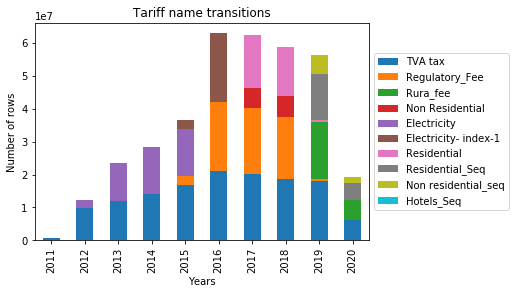

In [10]:
tariff_df.plot(kind='bar', stacked=True)
plt.ylabel('Number of rows')
plt.xlabel('Years')
plt.title('Tariff name transitions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Vending categories transitioning over time

In [ ]:
%%time
df['transaction_date'] = dd.to_datetime(df.transaction_date)
df['Transaction_year']= df.transaction_date.dt.year
vending_df = pd.DataFrame(index=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
# vending_categories = ['1. T1 Tx FC1 AR CTS','3. T2 Tx FC1 AR CTS','2. T1 Tx FC1 AR STS','10. Residential',
#                       '11. Non Residential','2. CS T1 Tx AR STS','18. Small Industries','15. Hotels',
#                      '16. Health Facilities','12. Specific','T7.CS INDUSTRIAL',
#                      'T7. INDUSTRIAL','6. T1 Tx FC1 AR STS','5. T3 Tx FC1 AR STS','4. T3 Tx FC1 AR CTS',
#                      '1. CS Tx AR CTS','19. Medium Industries','17. Broadcasters',
#                      '14. WTP and WPS','13. Telecom Towers','T8-MV-Line-Tx']    
vending_categories = ['1. T1 Tx FC1 AR CTS','2. T1 Tx FC1 AR STS','10. Residential',
                      '11. Non Residential','2. CS T1 Tx AR STS','18. Small Industries',
                     '15. Hotels','3. T2 Tx FC1 AR CTS','16. Health Facilities','12. Specific']
# vending_categories = ['1. T1 Tx FC1 AR CTS','16. Health Facilities','19. Medium Industries',
#                       '2. CS T1 Tx AR STS','18. Small Industries','15. Hotels','12. Specific',
#                      '3. T2 Tx FC1 AR CTS']
for n in vending_categories:
    data = df[df['vending_category_name']== n]
    vending_df[n]= (pd.DataFrame(data.groupby(['Transaction_year'])['Transaction_year'].count().compute()).rename(columns={'Transaction_year': 'non'}))
vending_df  

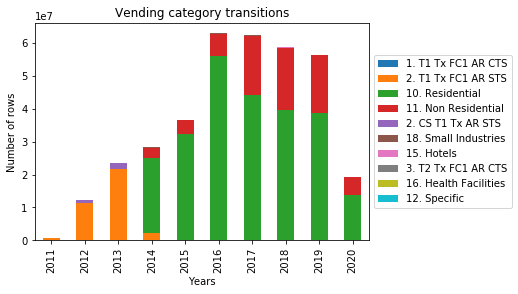

In [10]:
vending_df.plot(kind='bar', stacked=True)
plt.ylabel('Number of rows')
plt.xlabel('Years')
plt.title('Vending category transitions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Customers' transaction history

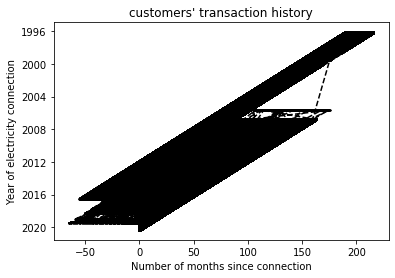

CPU times: user 14min 50s, sys: 39.1 s, total: 15min 29s
Wall time: 19min 56s


In [7]:
%%time
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

df['transaction_date'] = dd.to_datetime(df.transaction_date)a
df['installation_date'] = dd.to_datetime(df.installation_date)
df['months_since_installation'] = ((df.transaction_date - df.installation_date)/np.timedelta64(1, 'M'))

plt.plot(df['months_since_installation'].compute(), df['installation_date'].compute(),'.-',linestyle='--',color='k',markersize = 2.0)
plt.xlabel('Number of months since connection')
plt.ylabel('Year of electricity connection')
plt.gca().invert_yaxis()
plt.title('customers\' transaction history')
# plt.xlim(0)
plt.show()

### New installations per year

In [22]:
%%time
df['installation_date'] = dd.to_datetime(df.installation_date)
df['y'] = df['installation_date'].dt.strftime("%Y")
unique_conns_per_yr = df.groupby('y').consumer_id.nunique()
years = np.sort(df.y.unique())
# years = df.y.unique()

plt.bar(years,unique_conns_per_yr.compute())
plt.xticks(rotation=90)
plt.ylabel('Number of new connections')
plt.xlabel('Year of electricity connection')
plt.title('New connections per year')
plt.show()

KilledWorker: ("('pandas_read_text-read-block-from-delayed-b6fc327152b45ba923f207fb1d1035d8', 608)", <Worker 'tcp://10.128.0.14:33175', name: 0-0, memory: 0, processing: 692>)

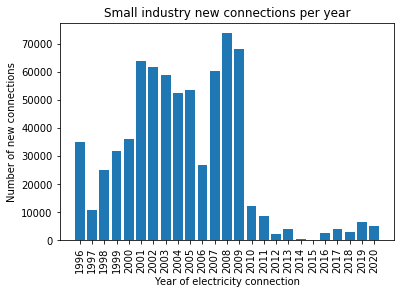

In [7]:
unique_conns_per_yr = df.groupby('y').consumer_id.nunique()
years = np.sort(df.y.unique())
# years = df.y.unique()

plt.bar(years,unique_conns_per_yr.compute())
plt.xticks(rotation=90)
plt.ylabel('Number of new connections')
plt.xlabel('Year of electricity connection')
plt.title('New connections per year')
plt.show()

### total transactions per customer

In [7]:
def group_by_transactions_per_customer(df):
    # 
    df["consumer_id"]= df["consumer_id"].astype(str)
    #df['consumer_id'] = df['consumer_id'].str.replace(" ","")
    gb_df = df.groupby(['consumer_id']).transaction_date.count().reset_index()
    gb_df = gb_df.set_index("consumer_id")
    gb_df.columns = ['Total_transactions']
    df = gb_df.compute()
    df = df.sort_values(by=['Total_transactions'], ascending=False)
    return df

In [8]:
%%time
group_by_transactions_per_customer(df)

CPU times: user 10.9 s, sys: 1.11 s, total: 12.1 s
Wall time: 2min 31s


,Total_transactions
consumer_id,
20121101 104121.689 0002032 0025,80285
252558,73028
20170428 173559.693 0002029 6495,56724
57114,53084
20120728 171633.140 0002016 0995,52639
...,...
195194,1
251411,1
204890,1


### total transactions per customer filtering out taxes

In [7]:
def group_by_transactions_per_customer_tarrifs(df):
    # 
    df["consumer_id"]= df["consumer_id"].astype(str)
    df['consumer_id'] = df['consumer_id'].str.replace(" ","")
    print(f'df len is: {len(df)}')
    df = df[df['transaction_item_type']=='TARIFF']
    print(f'df_filtered len is: {len(df)}')
    gb_df = df.groupby(['consumer_id']).transaction_date.count().reset_index()
    gb_df = gb_df.set_index("consumer_id")
    gb_df.columns = ['Total_transactions']
    df = gb_df.compute()
    df = df.sort_values(by=['Total_transactions'], ascending=False)
    return df

In [8]:
%%time
group_by_transactions_per_customer_tarrifs(df)

df len is: 361029383
df_filtered len is: 137484825
CPU times: user 24.1 s, sys: 1.77 s, total: 25.9 s
Wall time: 6min 36s


,Total_transactions
consumer_id,
252558,28307
20121101104121.68900020320025,26923
20170428173559.69300020296495,19746
57114,19432
20120728171633.14000020160995,18194
...,...
20191011161438.06000024002221,1
20191223160032.15100024007493,1
20190822092400.71800024008252,1


### Filter out customers

In [7]:
def groupby_customer(df, value, filter=True):
    
    df["consumer_id"]= df["consumer_id"].astype(str)
    df['consumer_id'] = df['consumer_id'].str.replace(" ","")
    gb_df = df.groupby(['consumer_id'])
    if filter:
        dataframe = gb_df.get_group(value)
        dataframe = dataframe.loc[:,['consumer_id','transaction_date','installation_date','vending_category_name',
                                     'transaction_item_type','tariff_name',
                                     'block_index','block_start_value','block_amount','kWh_sold','amount']]
        dataframe = dataframe.compute()
        dataframe = dataframe.sort_values(by=['transaction_date'], ascending=True)
    else:
        dataframe = (gb_df.get_group(value)).compute()
    return dataframe 

In [8]:
%%time
customer1 = groupby_customer(df,"163704") 
customer2 = groupby_customer(df,"240557")  
customer3 = groupby_customer(df,"20121003111626.90500020253685")
customer4 = groupby_customer(df,"20191220144819.08900024004945")
customer5 = groupby_customer(df,"20190314110412.57900020356750")

CPU times: user 58.8 s, sys: 4.59 s, total: 1min 3s
Wall time: 29min 8s


In [9]:
(customer1)

,consumer_id,transaction_date,installation_date,vending_category_name,transaction_item_type,tariff_name,block_index,block_start_value,block_amount,kWh_sold,amount
279530,163704,2011-12-02 13:15:37.380000000,2010-10-20 10:51:50,2. T1 Tx FC1 AR STS,TAX,TVA tax,NaN,NaN,NaN,0.0,229.0


In [10]:
(customer2)

,consumer_id,transaction_date,installation_date,vending_category_name,transaction_item_type,tariff_name,block_index,block_start_value,block_amount,kWh_sold,amount
271422,240557,2012-02-24 19:02:59.463000000,2011-10-05 11:50:21,2. T1 Tx FC1 AR STS,TAX,TVA tax,NaN,NaN,NaN,0.0,1373.0


In [11]:
(customer3)

,consumer_id,transaction_date,installation_date,vending_category_name,transaction_item_type,tariff_name,block_index,block_start_value,block_amount,kWh_sold,amount
244421,20121003111626.90500020253685,2012-10-03 15:10:13.297000000,2012-10-03 11:17:46,2. T1 Tx FC1 AR STS,TAX,TVA tax,NaN,NaN,NaN,0.0,229.0


In [12]:
(customer4)

,consumer_id,transaction_date,installation_date,vending_category_name,transaction_item_type,tariff_name,block_index,block_start_value,block_amount,kWh_sold,amount
170267,20191220144819.08900024004945,2020-02-03 11:21:10.977000000,2019-12-20 14:48:19,10. Residential,TAX,TVA tax,NaN,NaN,NaN,0.0,76.271
170268,20191220144819.08900024004945,2020-02-03 11:21:10.977000000,2019-12-20 14:48:19,10. Residential,TAX,Rura_fee,NaN,NaN,NaN,0.0,1.267
170269,20191220144819.08900024004945,2020-02-03 11:21:10.977000000,2019-12-20 14:48:19,10. Residential,TARIFF,Residential_Seq,0.0,0.0,89.0,4.8,422.462


In [13]:
(customer5)

,consumer_id,transaction_date,installation_date,vending_category_name,transaction_item_type,tariff_name,block_index,block_start_value,block_amount,kWh_sold,amount
210311,20190314110412.57900020356750,2019-07-15 07:33:32.957000000,2019-03-14 11:05:19,10. Residential,TAX,Rura_fee,NaN,NaN,NaN,0.0,1.267
210312,20190314110412.57900020356750,2019-07-15 07:33:32.957000000,2019-03-14 11:05:19,10. Residential,TAX,TVA tax,NaN,NaN,NaN,0.0,76.271
210313,20190314110412.57900020356750,2019-07-15 07:33:32.957000000,2019-03-14 11:05:19,10. Residential,TARIFF,Residential_Seq,0.0,0.0,89.0,4.8,422.462


### min, median and max number of transactions 

In [24]:
def transaction_stats_customers(df):

    # Transaction statistics for all consumers
    group_by_transactions_per_consumer = df.groupby(['consumer_id']
                                            ).transaction_date.count(
                                                    ).reset_index().compute()
    group_by_transactions_per_consumer.columns = ['consumer_id',
                                                  'Total_transactions']
    transaction_stats = group_by_transactions_per_consumer.Total_transactions.agg(
                                                            ['min','median', 'max'])
    print ('\nCustomer transaction statistics:  \n'+str(transaction_stats))

In [25]:
%%time
transaction_stats_customers(df)


Customer transaction statistics:  
min           1.0
median      143.0
max       80285.0
Name: Total_transactions, dtype: float64
CPU times: user 8.63 s, sys: 680 ms, total: 9.31 s
Wall time: 4min 47s


### missing data

In [7]:
def count_missing(df):
    print ('\nMissing values per column:')
    mis_val = df.isnull().sum().compute()
    mis_val_percent = 100 * df.isnull().sum().compute() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [8]:
%%time
count_missing(df)


Missing values per column:
Your selected dataframe has 18 columns.
There are 3 columns that have missing values.
CPU times: user 10.9 s, sys: 834 ms, total: 11.8 s
Wall time: 2min 29s


,Missing Values,% of Total Values
block_index,223548167,61.9
block_start_value,223548167,61.9
block_amount,223548167,61.9


### group by vending category and customers and filter by tax & tariff transactions

In [10]:
def groupby_customers_vendingcategory_filter_transactionitemtype(df,):

    df = df
    df_tariff = df[df['transaction_item_type']=='TARIFF']
    df_tax = df[df['transaction_item_type']=='TAX']    
    
    grouped = df.groupby(['vending_category_name','consumer_id']).size().reset_index().groupby('vending_category_name')[[0]].count()    
    grouped.columns = ['Total_customers']
    all_customers =  (grouped.Total_customers.sum())#.compute()).compute()
    percent_customers = (100 * np.divide(grouped.Total_customers,all_customers)).round(1)
    grouped['%_total_customers'] = percent_customers
    df = grouped.compute()
    df = df.sort_values(by=['%_total_customers'], ascending=False)
    print (f'Total number of customers in all categories combined is: {df.Total_customers.sum()}')
    
    grouped_tariff = df_tariff.groupby(['vending_category_name','consumer_id']).size().reset_index().groupby('vending_category_name')[[0]].count()    
    grouped_tariff.columns = ['Total_Tariff_customers']
    all_tariff_customers =  (grouped_tariff.Total_Tariff_customers.sum())#.compute()).compute()
    percent_Tariff_customers = (100 * np.divide(grouped_tariff.Total_Tariff_customers,all_tariff_customers)).round(1)
    grouped_tariff['%_total_Tariff_customers'] = percent_Tariff_customers
    df_tariff = grouped_tariff.compute()
    df_tariff = df_tariff.sort_values(by=['%_total_Tariff_customers'], ascending=False)
    print (f'Total number of tarrif customers in all categories combined is: {df_tariff.Total_Tariff_customers.sum()}')
    
   
    grouped_tax = df_tax.groupby(['vending_category_name','consumer_id']).size().reset_index().groupby('vending_category_name')[[0]].count()    
    grouped_tax.columns = ['Total_Tax_customers']
    all_customers =  (grouped_tax.Total_Tax_customers.sum())#.compute()).compute()
    percent_customers = (100 * np.divide(grouped_tax.Total_Tax_customers,all_customers)).round(1)
    grouped_tax['%_total_Tax_customers'] = percent_customers
    df_tax = grouped_tax.compute()
    df_tax = df_tax.sort_values(by=['%_total_Tax_customers'], ascending=False)
    print (f'Total number of tax customers in all categories combined is: {df_tax.Total_Tax_customers.sum()}')
    
    df['Total_Tariff_customers'] , df['%_total_Tariff_customers'],df['Total_Tax_customers'] , df['%_total_Tax_customers'] = df_tariff.Total_Tariff_customers,df_tariff['%_total_Tariff_customers'], df_tax.Total_Tax_customers, df_tax['%_total_Tax_customers']
    
    print (f'Total number of customers in entire dataset is: {total_unique_customers}')
    return df

In [11]:
groupby_customers_vendingcategory_filter_transactionitemtype(df,)

tariff len: 137484825
Total number of customers in all categories combined is: 1163280
Total number of tarrif customers in all categories combined is: 1127828
Total number of tax customers in all categories combined is: 1160720
Total number of customers in entire dataset is: 833621


,Total_customers,%_total_customers,Total_Tariff_customers,%_total_Tariff_customers,Total_Tax_customers,%_total_Tax_customers
vending_category_name,,,,,,
10. Residential,576426,49.6,576365,51.1,576369,49.7
2. T1 Tx FC1 AR STS,472699,40.6,443909,39.4,470213,40.5
11. Non Residential,88014,7.6,87981,7.8,87997,7.6
2. CS T1 Tx AR STS,16064,1.4,15781,1.4,16064,1.4
1. T1 Tx FC1 AR CTS,7670,0.7,1569,0.1,7670,0.7
1. CS Tx AR CTS,338,0.0,191,0.0,338,0.0
T7.CS INDUSTRIAL,3,0.0,2,0.0,3,0.0
T7. INDUSTRIAL,16,0.0,12,0.0,16,0.0
6. T1 Tx FC1 AR STS,2,0.0,2,0.0,2,0.0


In [ ]:
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

### split on date

In [7]:
def split_on_date(df):
    split_date = "2017-01-01"
    #split_date_dt = datetime.strptime(split_date, '%Y-%m-%d')
    #print (split_date_dt)
    df = df.set_index(df['transaction_date'])
    df_before_2017 = df[:split_date]
    df_after_2017  = df[split_date:]
    return  df_before_2017,  df_after_2017

### vending categories list

In [8]:
def vending_categories(df):


    vend_cats = [ n for n in df.vending_category_name.unique()]
    
    return vend_cats 

### dataframes broken by vending category

In [44]:
def vending_dataframes(df):
    cat = '11. Non Residential'
    grouped = df.groupby(['vending_category_name']) 
    fname = cat+'.csv'
    fpath = os.path.join(dir_path, fname)
    df = grouped.get_group(cat).compute()
    df.to_csv(fpath,index=False,header=True)
    return True

In [45]:
%%time
#before2017, after2017 =split_on_date(df)
vendor_cat_list = 'sd'#vending_categories(before2017)
vending_dataframes(df,vendor_cat_list)

CPU times: user 15min 56s, sys: 1min 8s, total: 17min 5s
Wall time: 17min 28s


True

In [ ]:
print ("My program took", convert(time.time() - start_time), "to run")

In [7]:
#meter_dataframe = df.meter_serial_number.unique().compute()
#meter_dataframe.to_csv(path_or_buf ='/mnt/nfs/work1/jtaneja/jmugyenyi/meter_ids.csv',index=False,header=True)